# EAGE Digital Geosciences Hackathon 2019
## Prediction of Missing Well Log Data
## Linear regression, Bayesian Regression Solution with MCMC and Gradient Boosting Regressor

### Overview

The problem we attempted to solve is a regression problem in which we try to predict shear wave velocities (expressed as slowness, $DTS$) for wells which are missing this log type. A different choice can be made. During the hackathon we opted to develop a model using a synthetic dataset with the following data:

  * $DTS$ - Shear wave slowness ($\mu s / ft$)
  * $DTC$ - Compressional wave slowness ($\mu s / ft$)
  * $\rho_b$ - Rock density  ($gm/cm^3$)
  * $x$ - The x coordinates of well log sample points
  * $y$ - The y coordinates of well log sample points
  * $z$ - The depths of well log sample points
  
Our model estimates $DTS$ using $DTC$, and $\rho_b$. A different choice can be made.

The model is applied on Marmousi2 synthetic data.

### Background Material

  * MCMC Introduction: https://www.tweag.io/posts/2019-10-25-mcmc-intro1.html
  * Various MCMC Examples (implemented in Python): https://docs.pymc.io/nb_examples/index.html
  * Bayesian Regression (implemented in Stan): https://mc-stan.org/docs/2_18/stan-users-guide/linear-regression.html
  * Marmousi2 synthetic data: https://wiki.seg.org/wiki/AGL_Elastic_Marmousi
  

### Data Pre-processing and Analysis

In [1]:
# Load jupyter extensions.
%load_ext autoreload

In [2]:
# Set jupyter to reload modules prior to execution.
%autoreload 2

In [3]:
# Python dependencies.
import os

import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn
import theano
import random

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.ensemble import GradientBoostingRegressor
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import mean_squared_error 
%matplotlib inline

The data for all well logs in our dataset is already prepared as a csv file caled all_synthetic_well_logs.csv and can be read into a pandas DataFrame. The wl_path variable must be updated with the filepath to all_synthetic_well_logs.csv on your machine:

In [4]:
# Load and display the data.
wl_path = '/home/aline/Documents/Travail/06_Hackathon/Applications/Marmousi2/data/all_synthetic_well_logs.csv'  # Change the path to fit your file organization
curve_df = pd.read_csv(wl_path)
curve_df.head()

,Unnamed: 0,DTC,DTS,RHOB,depth,well,x,y
0,0,NaN,NaN,NaN,0.00,6782,8476.25,0.0
1,1,NaN,NaN,NaN,1.25,6782,8476.25,0.0
2,2,NaN,NaN,NaN,2.50,6782,8476.25,0.0
3,3,NaN,NaN,NaN,3.75,6782,8476.25,0.0
4,4,NaN,NaN,NaN,5.00,6782,8476.25,0.0


For fitting our model, we need to drop all rows with missing (na) values:

In [5]:
# Drop all rows with missing (na) values and display the data. 
# In our Marmousi2 data, the missing values correspond to the water layer.
curve_df = curve_df.dropna()
curve_df.head()

,Unnamed: 0,DTC,DTS,RHOB,depth,well,x,y
361,361,202.660803,1047.141755,1.950106,451.25,6782,8476.25,0.0
362,362,202.123242,1036.177384,1.951479,452.50,6782,8476.25,0.0
363,363,201.588524,1025.440245,1.952849,453.75,6782,8476.25,0.0
364,364,201.056628,1014.924170,1.954217,455.00,6782,8476.25,0.0
365,365,200.527532,1004.620786,1.955583,456.25,6782,8476.25,0.0


To mimic real case applications, we split our data into a test and training dataset at the well level (as opposed to splitting on the measurement level). This allows for plotting of entire predicted DTS well logs which provides a nicer visual check on our model estimates.

In [6]:
# Randomly split our data into a test and training dataset, the training dataset is here 0.05% of the total dataset. 
wells = curve_df.well.unique()
train_wells, test_wells = train_test_split(wells, test_size=0.9995)

# Get curve data and shuffle datasets.
train_curves = curve_df[curve_df.well.isin(train_wells)].sample(frac=1).reset_index(drop=True)
test_curves = curve_df[curve_df.well.isin(test_wells)].sample(frac=1).reset_index(drop=True)

Before building our model, we perform some preliminary checks on our training dataset to try to better understand the "natural" relationships between our data:

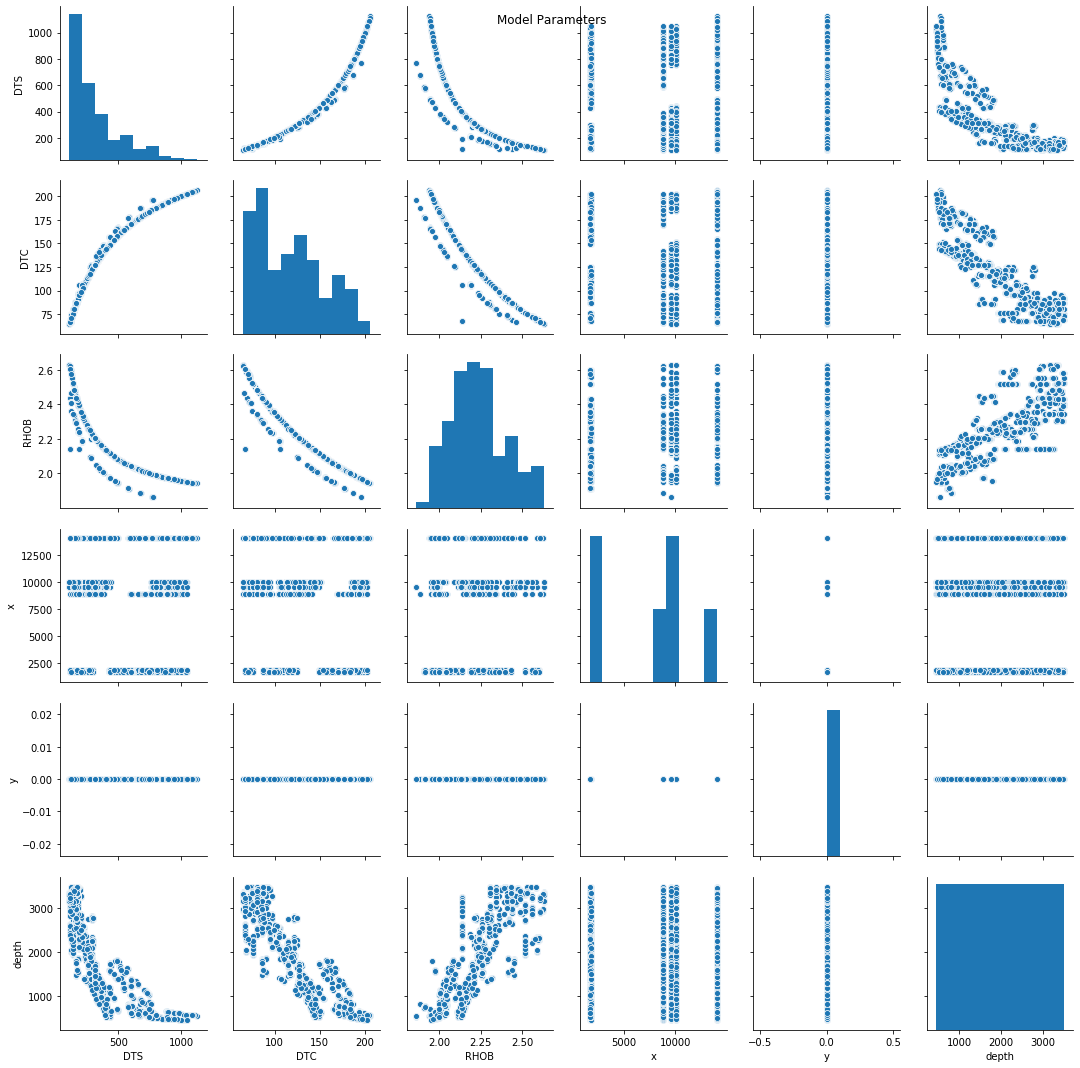

In [7]:
# Pair plots are a nice way of doing this. 
pp = seaborn.pairplot(train_curves.sample(frac=1)[["DTS", "DTC", "RHOB", "x", "y", "depth"]])
pp.fig.suptitle('Model Parameters')
plt.show()

We can see some interesting features in our dataset: 

  1. Constant values for y - since our dataset is along a 2D profile, all y values are the same. We will therefore ignore y for the rest of our model.  Adding a term for y for real-world models can be done in a similar manner to how DTC is handled in this example. 
  2. x and depth are also ignored.
  3. The data are indeed sampled at the well level (as opposed to splitting on the measurement level), the spatial sampling is provided by the plots involving the x variable. 
  4. As expected from our choice of training dataset, the well level sampling is sparse and non uniform.
  5. A strong correlation between DTC, DTS and RHOB exists. 
  6. Non-linearities in the relationships DTC vs. DTS, RHOB vs. DTS and RHOB vs. DTC. 
  7. Weak (and non-linear) correlation between depth and the log curves.
  8. Even weaker (and non-linear) correlation between x and the log curves.
  9. Wildly different numerical scales for each of our model parameters.
  
The observed correlations are consistent with how our synthetic Marmousi2 dataset was generated (see below), and would likely be far more noisy in real-world data. 

From Martin (2004) (Martin, G. S., 2004, <i> The Marmousi2 model, elastic synthetic data, and an analysis of imaging and AVO in a structurally complex environment </i> , Master’s thesis, University of Houston):

Marmousi2 dataset is based upon a real marine environment from the North Quenguela Trough in the Quanza Basin. Marmousi2 dataset is an isotropic elastic dataset made up of four different type of lithologies: mainly shale units, with occasional sand, marl (carbonate rich shales, defined in this model as 70% shale, 30% limestone) and salt layers with following properties and distribution:

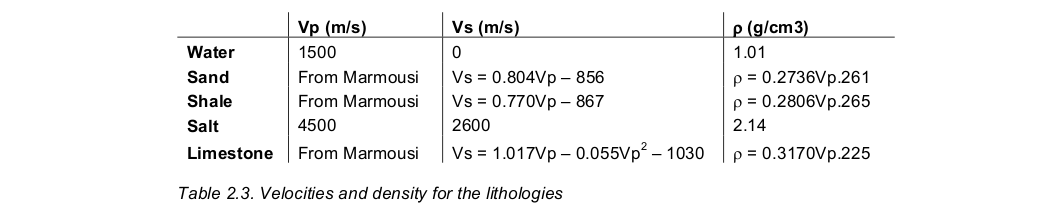

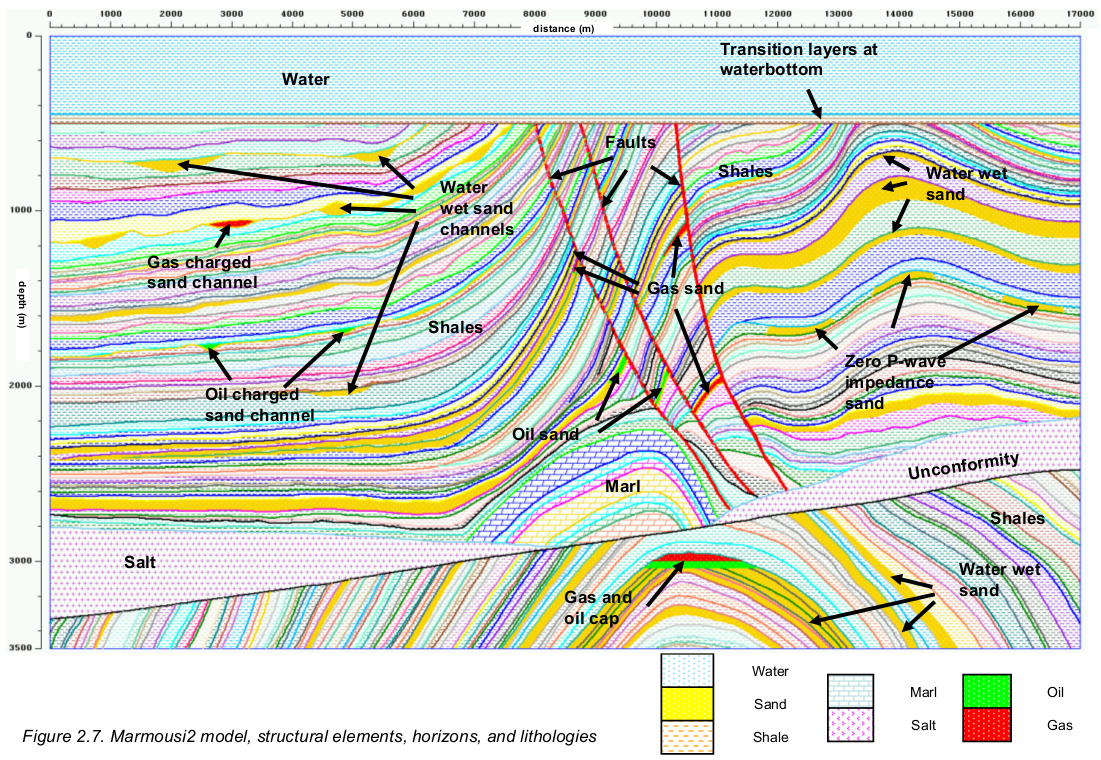

The data also contains 10 hydrocarbon sand reservoirs with various gas/oil ratios, affecting the properties of the subsurface.

These observations will help inform us when we write our model.
  

Now we can normalize our parameters. Normalization (via scaling and shifting) is done to improve the performance of our prediction algorithms.

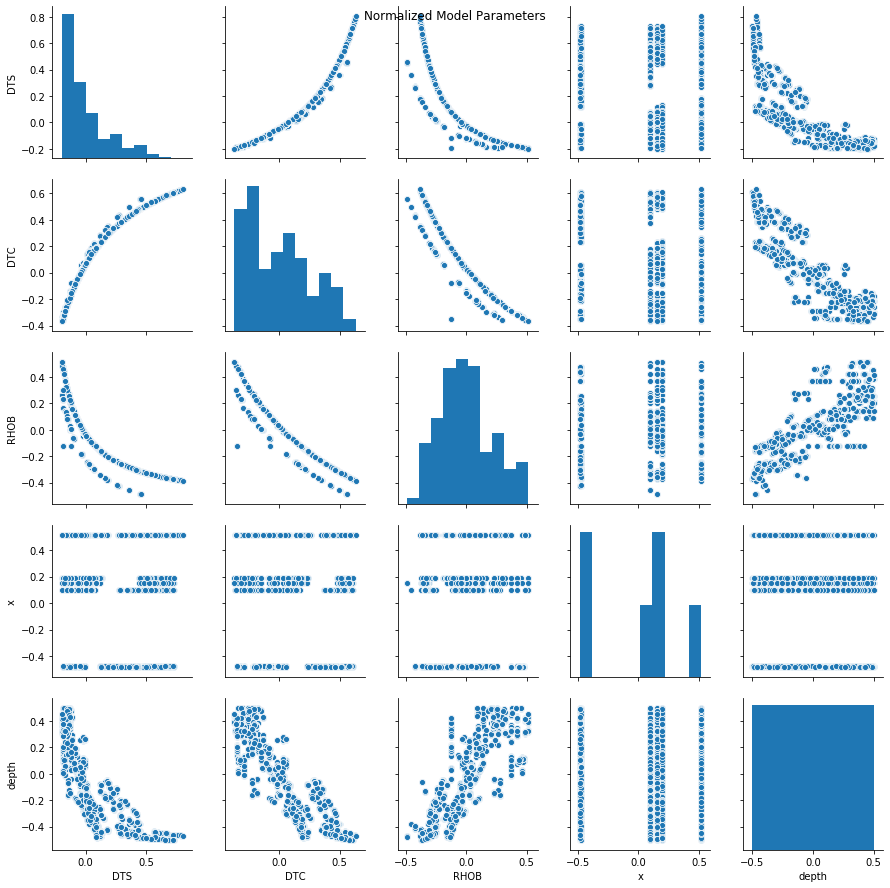

In [8]:
scale_factors = {}
shift_factors = {}
norm_columns = ["DTC", "DTS", "RHOB","x","depth"]

# Storing the normalization terms here since we will need it to transform our posterior predictions
for c in norm_columns:
    scale_factors[c] = np.abs(train_curves[c].max() - train_curves[c].min())
    shift_factors[c] = train_curves[c].mean()
    train_curves.loc[:, c] = (train_curves.loc[:, c] - shift_factors[c]) / scale_factors[c]

# We also need to normalize our test data (by the same factor as our training data)
for c in norm_columns:
    test_curves.loc[:, c] = (test_curves.loc[:, c] - shift_factors[c]) / scale_factors[c]

# Pair plots of normalized model parameters
pp = seaborn.pairplot(train_curves.sample(frac=1)[["DTS", "DTC", "RHOB", "x", "depth"]])
pp.fig.suptitle('Normalized Model Parameters')
plt.show()

### Prediction with Linear Regression

In [9]:
# These are the features - independent variables / abscissa
features = ['DTC', 'RHOB']

# Target variable - dependent variable / ordinate
target = ['DTS']

# Here we are selecting the proper columns for training and evaluating the model
X = train_curves[features]
y = train_curves[target]

In [10]:
# These two lines create the linear regression model and fit it to the data contained in X and y 
reg = linear_model.LinearRegression(fit_intercept=True)
reg.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

2726
-0.34492150493975665


/home/aline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


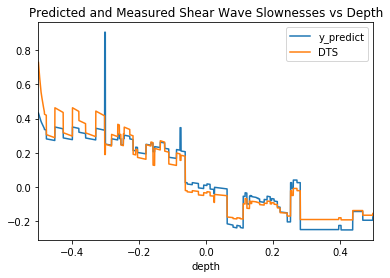

In [11]:
# The regression model we created up above has a 'predict' function attached to it that lets us submit more data 
# Here we submit a randomly chosen whole well from the test dataset.
welln_test = random.choice(test_curves.well)
test_curve = test_curves[test_curves.well == welln_test]
# Print tested well number then normalized x location
print(welln_test)
print(np.mean(test_curve["x"]))
# We have the true values for this well, so we can compare them both and see how the regression fits.
test_curve['y_predict'] = reg.predict(test_curve[features])
# Plot normalized comparison
test_curve_sorted=test_curve.sort_values(by=['depth'])
test_curve_sorted[['y_predict', 'DTS', 'depth']].plot(x='depth', title='Predicted and Measured Shear Wave Slownesses vs Depth')

In [12]:
# Looking at the mean squared error between the predicted values and the true normalized values.
mean_squared_error(test_curve.y_predict, test_curve.DTS)

0.0038831550602790844

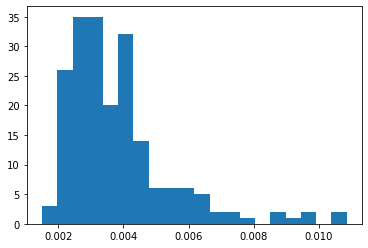

In [13]:
# Here we are taking a random pair of wells, one from the training set, the other one from the test set, using one for learning, one for testing.
# For each pair, the mean squared error is computed and a histogram of mean squared errors is made.
perf= []
for x in range(200):
    welln_train_sample = random.choice(train_curves.well)
    welln_test_sample = random.choice(test_curves.well)
    train_curve_sample = train_curves[train_curves.well == welln_train_sample]
    test_curve_sample = test_curves[test_curves.well == welln_test_sample]
    X, y = train_curve_sample[features], train_curve_sample[target]
    X_test, y_test = test_curve_sample[features], test_curve_sample[target]
    reg = linear_model.LinearRegression(fit_intercept=True)
    reg.fit(X, y.values.ravel())
    perf.append(mean_squared_error(reg.predict(X_test), y_test.values.ravel()))
hist_args = plt.hist(perf, bins=20)

### Prediction with Bayesian Boosting Regressor

In [14]:
#Here we are selecting the proper columns for training and evaluating the model
X = train_curves[features]
y = train_curves[target]

gbr_reg = GradientBoostingRegressor()
gbr_reg.fit(X, y)

/home/aline/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

/home/aline/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


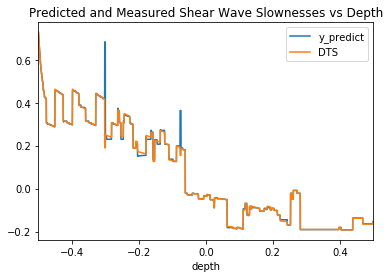

In [15]:
# Here we test on the same well as previously
test_curve['y_predict'] = gbr_reg.predict(test_curve[features])
test_curve_sorted=test_curve.sort_values(by=['depth'])
test_curve_sorted[['y_predict', 'DTS', 'depth']].plot(x='depth', title='Predicted and Measured Shear Wave Slownesses vs Depth')

In [16]:
mean_squared_error(test_curve.y_predict, test_curve.DTS)

0.0006451065028534993

/home/aline/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/aline/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/aline/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/aline/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when 

/home/aline/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/aline/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/aline/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/aline/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when 

/home/aline/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/aline/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/aline/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/aline/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when 

/home/aline/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/aline/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/aline/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/aline/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when 

/home/aline/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/aline/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/aline/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/aline/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when 

/home/aline/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/aline/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/aline/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/aline/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when 

/home/aline/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/aline/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/aline/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/aline/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when 

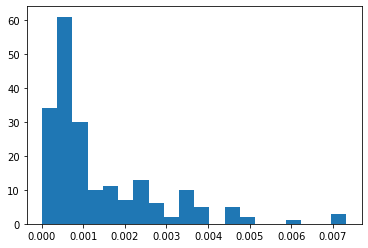

In [17]:
# Here we are taking a random pair of wells, one from the training set, the other one from the test set, using one for learning, one for testing.
# For each pair, the mean squared error is computed and a histogram of mean squared errors is made.
perf= []
for x in range(200):
    welln_train_sample = random.choice(train_curves.well)
    welln_test_sample = random.choice(test_curves.well)
    train_curve_sample = train_curves[train_curves.well == welln_train_sample]
    test_curve_sample = test_curves[test_curves.well == welln_test_sample]
    X, y = train_curve_sample[features], train_curve_sample[target]
    X_test, y_test = test_curve_sample[features], test_curve_sample[target]
    gbr_reg = GradientBoostingRegressor()
    gbr_reg.fit(X, y)
    perf.append(mean_squared_error(gbr_reg.predict(X_test), y_test.values.ravel()))
hist_args = plt.hist(perf, bins=20)

### Prediction with MCMC

#### Model Definition and Training

With our data normalized, we're ready to define our MCMC model. For a good introduction to MCMC, I recommend taking a look at this introductory
article from Tweag: https://www.tweag.io/posts/2019-10-25-mcmc-intro1.html.

Our posterior distribution can be defined as:

$P(m | d) = \frac{P(d | m)*P(m)}{P(d)}$

Where:
  
 $ m = [DTS]$
 
 $ d = [DTC, RHOB]$

This can be expressed in pymc3 as follows:

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b_dtc, b_rho, alpha, sigma_mod]
Sampling 4 chains: 100%|██████████| 6000/6000 [02:10<00:00, 45.93draws/s]
The acceptance probability does not match the target. It is 0.9489363531006949, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9180077700903414, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.923669972372538, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9299561175990492, but should be close to 0.8. Try to increase the number of tuning steps.


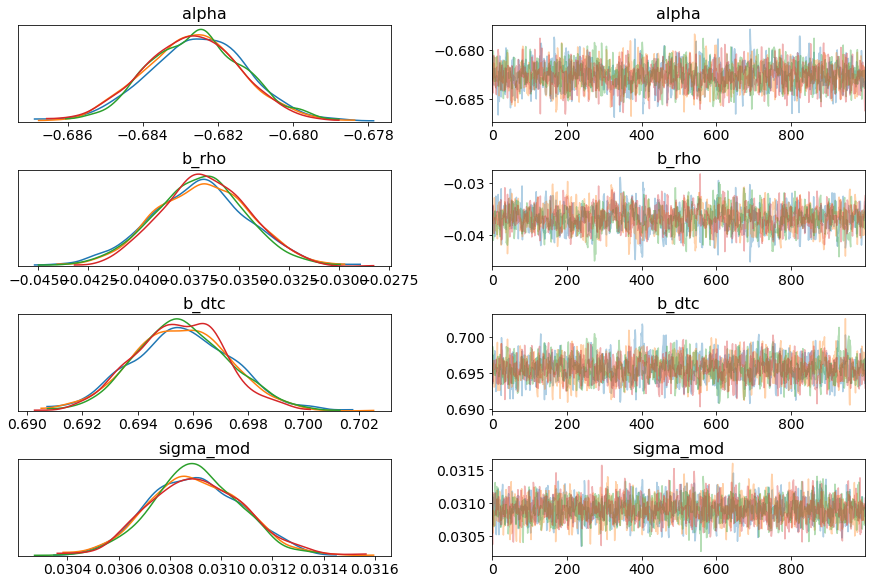

In [18]:
# You MUST define theano tensors for running the model.
#   we end up updating the values of these tensors to
#   generate our posterior predictions after training
#   our model.
shared_dtc = theano.shared(train_curves.DTC.values)
shared_rhob = theano.shared(train_curves.RHOB.values)
#shared_x = theano.shared(train_curves.x.values)
#shared_y = theano.shared(train_curves.y.values)
#shared_depth = theano.shared(train_curves.depth.values)
shared_dts = theano.shared(train_curves.DTS.values)

with pm.Model() as linear_model:
    ## -- Prior definitions for model parameters --
    # Priors are one of the core tools in Bayesian statistics.
    # They allow you to encode a-priori beliefs into your
    # model with associated unceratinties.
    
    # sigma_mod is our modelization uncertainty
    sigma_mod = pm.HalfNormal('sigma_mod', 2)
    # intercept (alpha) and regression coefficients b_*
    alpha = pm.Normal('alpha', sigma=1)
    b_rho = pm.Normal('b_rho', sigma=1)
    b_dtc = pm.Normal('b_dtc', sigma=1)
    #b_x = pm.Normal('b_x', sigma=1)
    # b_y = ...
    #b_depth = pm.Normal('b_depth', sigma=1)
    
    # We can define nonlinear transformations if we think our
    #  features aren't well described by a simple linear relationship.
    #   Note: you need to use theano tensor math here (i.e. not numpy)
    dtc_transformed = theano.tensor.exp(shared_dtc)
    rhob_transformed = theano.tensor.exp(theano.tensor.neg(shared_rhob))
    # ...
    
    
    #  -- Transform parameters into a predicted DTS --
    dts_pred = alpha + \
           (b_dtc * dtc_transformed) + \
           (b_rho * rhob_transformed) #+ \
           #(b_depth * shared_depth) + \
           #(b_x * shared_x)
    
    # -- Likelihood function definition --
    dts_obs = pm.Normal(
        'dts_obs', 
        mu=dts_pred, 
        sigma=sigma_mod,
        observed=shared_dts)
    
    # -- Sample! --
    trace = pm.sample(1000 , cores=4)
    
    # And, plot the traces for our model parameters
    pm.plots.traceplot(trace)


Our sampling seems to have succeeded - it exited without throwing any diagnostic warnings ("The acceptance probability does not match the target" is not a point of concern, we would mainly be concerned with divergent transitions and high Gelman-Rubin values for the NUTS sampler we are using) and our traces seem to be mixing well in the following traceplot. 

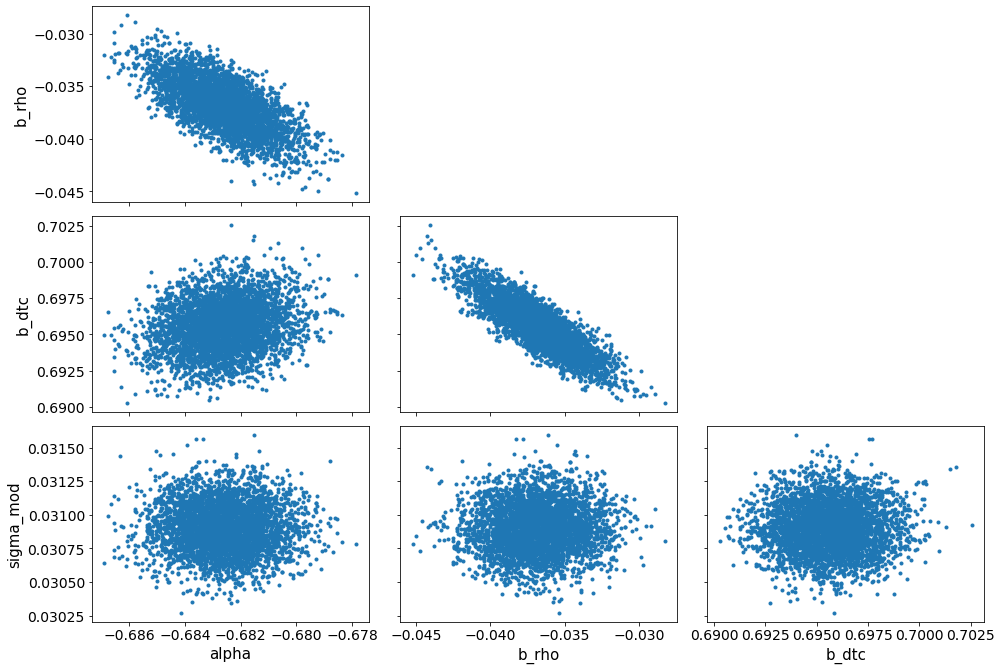

In [19]:
pm.plot_pair(trace)
plt.show()

#### Generating Posterior Predictions for Test Dataset

In [24]:
# Update data tensors with test data
shared_dtc.set_value(test_curve.DTC.values)
shared_rhob.set_value(test_curve.RHOB.values)
#shared_x.set_value(test_curve.x.values)
#shared_y.set_value(test_curve.y.values)
#shared_depth.set_value(test_curve.depth.values)

# Produce posterior predictions
ppc = pm.sample_posterior_predictive(trace, model=linear_model)
dts_pred_norm = ppc["dts_obs"]
dts_pred = dts_pred_norm*scale_factors["DTS"] + shift_factors["DTS"]

# We need to restore our data and labels to un-normalized space for plotting and further analysis:
for c in norm_columns:
    test_curve.loc[:, c] = (test_curve.loc[:, c]*scale_factors[c]) + shift_factors[c]

100%|██████████| 4000/4000 [00:52<00:00, 76.26it/s]


In [25]:
# Extract quantiles for predictions
percentiles = np.percentile(dts_pred, [2.5, 50, 97.5], axis=0)
test_curve.loc[:, "PRED_DTS_2_5"] = percentiles[0,:]
test_curve.loc[:, "PRED_DTS_50"] = percentiles[1,:]
test_curve.loc[:, "PRED_DTS_97_5"] = percentiles[2,:]

# We can compute residual:
test_curve.loc[:, "RESIDUAL_50"] = test_curve["PRED_DTS_50"] - test_curve["DTS"]

# We can also compute the MSE for our median posterior prediction:
p50_mse = (test_curve["RESIDUAL_50"]**2.0).sum() / test_curve.shape[0]

print("Median MSE: {}".format(p50_mse))

test_curve.describe()

Median MSE: 5889.695097121306


,Unnamed: 0,DTC,DTS,RHOB,depth,well,x,y,y_predict,PRED_DTS_2_5,PRED_DTS_50,PRED_DTS_97_5,RESIDUAL_50
count,2440.000000,2440.000000,2440.000000,2440.000000,2440.000000,2440.0,2440.00,2440.0,2440.000000,2440.000000,2440.000000,2440.000000,2440.000000
mean,1580.500000,126.663273,373.642169,2.197024,1975.625000,2726.0,3406.25,0.0,0.063661,308.965770,370.223518,431.468062,-3.418651
std,704.511651,43.886103,230.146731,0.184901,880.639564,0.0,0.00,0.0,0.228718,240.532900,240.532376,240.531785,76.683883
min,361.000000,66.842511,115.280578,1.589999,451.250000,2726.0,3406.25,0.0,-0.192231,8.978686,71.898988,131.612755,-190.167129
25%,970.750000,87.110160,155.731450,2.037895,1213.437500,2726.0,3406.25,0.0,-0.145392,93.448573,154.682251,216.060474,-25.055899
50%,1580.500000,120.031001,280.069855,2.139999,1975.625000,2726.0,3406.25,0.0,-0.029982,240.195618,301.622046,363.068762,-2.161848
75%,2190.250000,171.514017,604.798191,2.302706,2737.812500,2726.0,3406.25,0.0,0.294108,544.636558,607.192769,667.678544,17.516106
max,2800.000000,296.499852,1047.141755,2.606000,3500.000000,2726.0,3406.25,0.0,0.726258,1979.480586,2041.589458,2103.446307,1539.444733


In [26]:
pred_well_1 = test_curve.sort_values('depth')
pred_well_1.head()

,Unnamed: 0,DTC,DTS,RHOB,depth,well,x,y,y_predict,PRED_DTS_2_5,PRED_DTS_50,PRED_DTS_97_5,RESIDUAL_50
17135593,361,202.660803,1047.141755,1.950106,451.25,2726,3406.25,0.0,0.726258,794.272864,856.974626,918.025120,-190.167129
156250,362,202.123242,1036.177384,1.951479,452.50,2726,3406.25,0.0,0.715773,790.564458,851.488204,912.555592,-184.689180
30737867,363,201.588524,1025.440245,1.952849,453.75,2726,3406.25,0.0,0.704945,783.978766,846.521102,906.745683,-178.919143
16359725,364,201.056628,1014.924170,1.954217,455.00,2726,3406.25,0.0,0.696840,779.914369,841.551317,902.973718,-173.372853
3766791,365,200.527532,1004.620786,1.955583,456.25,2726,3406.25,0.0,0.683484,777.394983,838.261892,899.938365,-166.358894


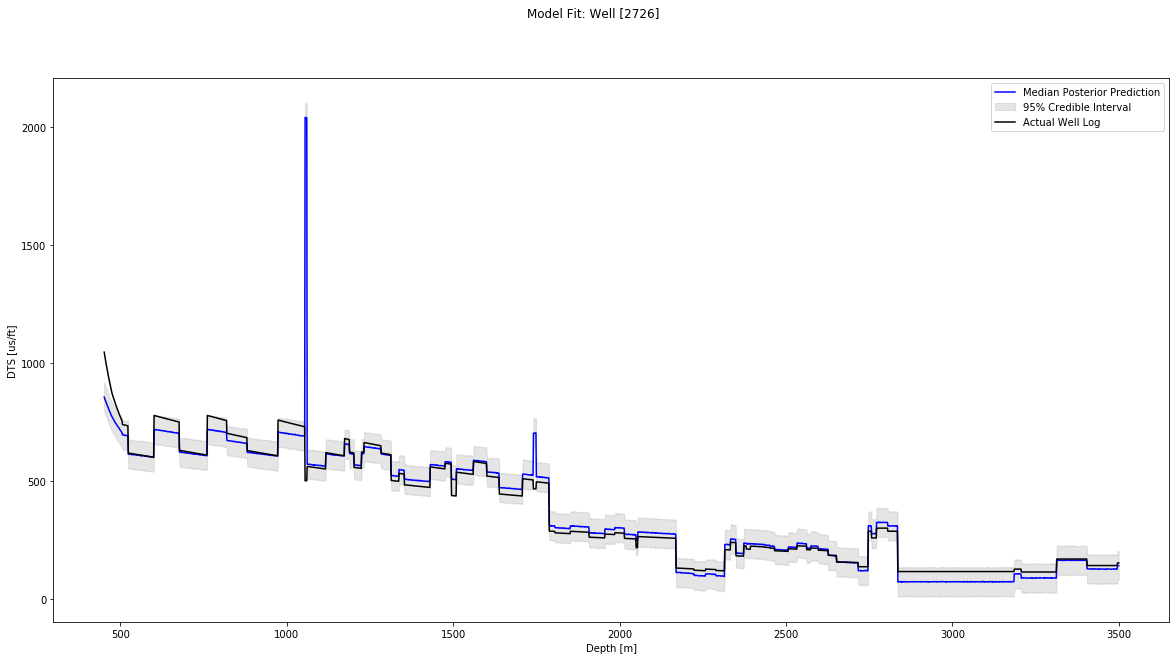

In [27]:
plt.figure(figsize=(20,10))
p_pred = plt.plot(pred_well_1.depth, pred_well_1.PRED_DTS_50, color='blue')
p_ci = plt.fill_between(pred_well_1.depth, pred_well_1.PRED_DTS_2_5, pred_well_1.PRED_DTS_97_5,
                         color='gray', alpha=0.2)
p_actual = plt.plot(pred_well_1.depth, pred_well_1.DTS, color='black')
plt.legend([p_pred[0], p_ci, p_actual[0]], ["Median Posterior Prediction", "95% Credible Interval", "Actual Well Log"])
plt.suptitle("Model Fit: Well {}".format(pred_well_1.well.unique()))
plt.ylabel("DTS [us/ft]")
plt.xlabel("Depth [m]")
plt.show()
